### Oil type by origin "Pacific" (general attribution)

Calculated as imports to WA terminals in Department of Ecology's recorded marine terminal transfers for 2018.  
Only transfers greater than 1000 L are required to be documented. All imports and exports are catalogued by vessel and oil types used in this study, across all the marine terminals used in this category. 

Use `analysis-rachael/env/monte_carlo.yaml` to create an environment for this notebook:
```
 conda env create -f [analysis-rachael/env/monte_carlo.yaml]
```
or, to activate this environment, use
```
 conda activate monte-carlo
```
To deactivate an active environment, use
```
 conda deactivate
```

NOTE: The strategy used in this code was improved upon but this code wasn't updated.  

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import yaml

In [20]:
# User inputs
yaml_input = pathlib.Path('/data/MIDOSS/marine_transport_data/')
yaml_output = pathlib.Path('/ocean/rmueller/MIDOSS/tmp_output')

# open oil_attribution.yaml for paths
oil_attribution_file = yaml_input / 'oil_attribution.yaml'
with open(oil_attribution_file) as file:
            oil_attrs = yaml.load(file, Loader=yaml.Loader)
        
# define file path for DOE data
doe_input = oil_attrs['files']['doe_transfers']

vessel_types = oil_attrs['categories']['tank_vessels']
fuel_types   = oil_attrs['categories']['fuel_type']

In [21]:
vessel_types

['tanker', 'atb', 'barge']

In [22]:
# Import columns are: (G) Deliverer, (H) Receiver, (P) Product, 
#                     (Q) Quantity in Gallons, (R) Transfer Type (Fueling, Cargo, or Other)', 
#                     (w) DelivererTypeDescription, (x) ReceiverTypeDescription 
df = pd.read_excel(doe_input, sheet_name='Vessel Oil Transfer', 
                   usecols="G,H,P,Q,R,W,X")

#### Extract cargo data transferred from vessel to facility

In [23]:
# list of names in DOE dataset that are used as "DelivererTypeDescription" for vessel transfers
vessel_names = ['TANK SHIP', 'TANK BARGE', 'TUGBOAT']
# Get all cargo fuel transfers
bool_cargo = df['TransferType']=='Cargo'
cargo_data = df[bool_cargo]
cargo_to_facility = cargo_data[ cargo_data['ReceiverTypeDescription']=='Facility' ]
cargo_from_tank   = cargo_to_facility[ cargo_to_facility['DelivererTypeDescription'] == 'TANK SHIP' ]
cargo_from_barge  = cargo_to_facility[ cargo_to_facility['DelivererTypeDescription'] == 'TANK BARGE' ] 
cargo_from_tug    = cargo_to_facility[ cargo_to_facility['DelivererTypeDescription'] == 'TUGBOAT' ]

# reset indices so they increase chronologically from 0 instead of keeping parent index values
cargo_from_tank.reset_index( drop=True, inplace=True )
cargo_from_barge.reset_index( drop=True, inplace=True )
cargo_from_tug.reset_index( drop=True, inplace=True )

In [24]:
[nrows,ncols] = cargo_from_barge.shape

In [25]:
# create ATB and tank barge dataframes
cargo_from_atb = pd.DataFrame(columns = cargo_from_barge.columns)
for row in range(nrows):
    if 'ITB' in cargo_from_barge.Deliverer[row] or 'ATB' in cargo_from_barge.Deliverer[row]:
        cargo_from_atb = cargo_from_atb.append( cargo_from_barge.iloc[row] )
        
for row in range(nrows):
    if 'ITB' in cargo_from_barge.Deliverer[row] or 'ATB' in cargo_from_barge.Deliverer[row]:        
        cargo_from_barge = cargo_from_barge.drop([row])

# reset indexing        
cargo_from_atb.reset_index( drop=True, inplace=True )

In [26]:
# concatenate tank barge dataframes
cargo_from_barge = pd.concat([cargo_from_barge, cargo_from_tug])

# reset indexing
cargo_from_barge.reset_index( drop=True, inplace=True )

### Total up the volume of fuel by fuel category for vessel types used in this study

In [27]:
# create dictionary structure
Pacific = {}
for vessel in vessel_types:
    Pacific[vessel]={}
    for fuel in fuel_types:
        Pacific[vessel][fuel]={}
        Pacific[vessel][fuel]['total_gallons']=0
        Pacific[vessel][fuel]['number_of_transfers']=0
        Pacific[vessel][fuel]['fraction_of_total']=0

#### Tankers

In [28]:
[nrows,ncols] = cargo_from_tank.shape
label = 'tanker'
for row in range(nrows):
    
    if 'CRUDE' in cargo_from_tank.Product[row]:
        Pacific[label]['akns']['total_gallons'] += cargo_from_tank.TransferQtyInGallon[row].item()
        Pacific[label]['akns']['number_of_transfers'] += 1

    elif cargo_from_tank.Product[row] == 'BUNKER OIL/HFO':
        Pacific[label]['bunker']['total_gallons'] += cargo_from_tank.TransferQtyInGallon[row].item()
        Pacific[label]['bunker']['number_of_transfers'] += 1

    elif cargo_from_tank.Product[row] == 'GASOLINE':
        Pacific[label]['gas']['total_gallons'] += cargo_from_tank.TransferQtyInGallon[row].item()
        Pacific[label]['gas']['number_of_transfers'] += 1

    elif cargo_from_tank.Product[row] == 'JET FUEL/KEROSENE':
        Pacific[label]['jet']['total_gallons'] += cargo_from_tank.TransferQtyInGallon[row].item()
        Pacific[label]['jet']['number_of_transfers'] += 1

    elif 'DIESEL' in cargo_from_tank.Product[row]: 
        # inclusive if BIODIESEL, DIESEL/MARINE GAS OIl, and DIESEL LOW SULPHUR (ULSD)
        Pacific[label]['diesel']['total_gallons'] += cargo_from_tank.TransferQtyInGallon[row].item()
        Pacific[label]['diesel']['number_of_transfers'] += 1

    else:
        Pacific[label]['other']['total_gallons'] += cargo_from_tank.TransferQtyInGallon[row].item()
        Pacific[label]['other']['number_of_transfers'] += 1    

In [29]:
Pacific[label]['other']['total_gallons']

240552010

#### ATBs

In [30]:
[nrows,ncols] = cargo_from_atb.shape
label = 'atb'
for row in range(nrows):
    
    if 'CRUDE' in cargo_from_atb.Product[row]:
        ### WHY DOES ADDING A .ITEM() HERE GIVE AN ERROR WHEN IT DOESN'T ABOVE?
        Pacific[label]['akns']['total_gallons'] += cargo_from_atb.TransferQtyInGallon[row]
        Pacific[label]['akns']['number_of_transfers'] += 1

    elif cargo_from_atb.Product[row] == 'BUNKER OIL/HFO':
        Pacific[label]['bunker']['total_gallons'] += cargo_from_atb.TransferQtyInGallon[row]
        Pacific[label]['bunker']['number_of_transfers'] += 1

    elif cargo_from_atb.Product[row] == 'GASOLINE':
        Pacific[label]['gas']['total_gallons'] += cargo_from_atb.TransferQtyInGallon[row]
        Pacific[label]['gas']['number_of_transfers'] += 1

    elif cargo_from_atb.Product[row] == 'JET FUEL/KEROSENE':
        Pacific[label]['jet']['total_gallons'] += cargo_from_atb.TransferQtyInGallon[row]
        Pacific[label]['jet']['number_of_transfers'] += 1

    elif 'DIESEL' in cargo_from_atb.Product[row]: 
        # inclusive if BIODIESEL, DIESEL/MARINE GAS OIl, and DIESEL LOW SULPHUR (ULSD)
        Pacific[label]['diesel']['total_gallons'] += cargo_from_atb.TransferQtyInGallon[row]
        Pacific[label]['diesel']['number_of_transfers'] += 1

    else:
        Pacific[label]['other']['total_gallons'] += cargo_from_atb.TransferQtyInGallon[row]
        Pacific[label]['other']['number_of_transfers'] += 1   

#### Barges

In [31]:
[nrows,ncols] = cargo_from_barge.shape
label = 'barge'

for row in range(nrows):
    
    if 'CRUDE' in cargo_from_barge.Product[row]:
        Pacific[label]['akns']['total_gallons'] += cargo_from_barge.TransferQtyInGallon[row].item()
        Pacific[label]['akns']['number_of_transfers'] += 1

    elif cargo_from_barge.Product[row] == 'BUNKER OIL/HFO':
        Pacific[label]['bunker']['total_gallons'] += cargo_from_barge.TransferQtyInGallon[row].item()
        Pacific[label]['bunker']['number_of_transfers'] += 1

    elif cargo_from_barge.Product[row] == 'GASOLINE':
        Pacific[label]['gas']['total_gallons'] += cargo_from_barge.TransferQtyInGallon[row].item()
        Pacific[label]['gas']['number_of_transfers'] += 1

    elif cargo_from_barge.Product[row] == 'JET FUEL/KEROSENE':
        Pacific[label]['jet']['total_gallons'] += cargo_from_barge.TransferQtyInGallon[row].item()
        Pacific[label]['jet']['number_of_transfers'] += 1

    elif 'DIESEL' in cargo_from_barge.Product[row]: 
        # inclusive if BIODIESEL, DIESEL/MARINE GAS OIl, and DIESEL LOW SULPHUR (ULSD)
        Pacific[label]['diesel']['total_gallons'] += cargo_from_barge.TransferQtyInGallon[row].item()
        Pacific[label]['diesel']['number_of_transfers'] += 1

    else:
        Pacific[label]['other']['total_gallons'] += cargo_from_barge.TransferQtyInGallon[row].item()
        Pacific[label]['other']['number_of_transfers'] += 1   


#### Determine percent oil for each oil type

In [32]:
for vessel in vessel_types:

    # first get the total transfers over all fuel types
    total = sum([ Pacific[vessel][fuel]['total_gallons'] for fuel in fuel_types ])

    for fuel in fuel_types:
  
        # next calculate percentages
        if total != 0:
            Pacific[vessel][fuel]['fraction_of_total'] = round(
                Pacific[vessel][fuel]['total_gallons'] / total, 
                4
            )
            
#  Check to make sure fraction of total sums to 1
for vessel in vessel_types:
    sum_check = [Pacific[vessel][fuel]['fraction_of_total'] for fuel in fuel_types]
    if sum(sum_check) != 1 and sum(sum_check) != 0:
        # add oil to "other" category to fix sum to 1
        shortfall  = 1-sum(sum_check)
        Pacific[vessel]['other']['fraction_of_total'] += shortfall
        print(f'{vessel} SHORTFALL:{shortfall} (corrected)')

        # double check
        sum_check = [Pacific[vessel][fuel]['fraction_of_total'] for fuel in fuel_types]
        if sum(sum_check) != 1 and sum(sum_check) !=0 :
            print(f'NOT THERE YET!: {vessel}, {facility}:{sum(sum_check_out)}')

    elif sum(sum_check) != 1:
        print(f' {vessel}:{sum(sum_check_in)}')
  



atb SHORTFALL:9.999999999998899e-05 (corrected)
barge SHORTFALL:9.999999999987796e-05 (corrected)


In [33]:
with open(yaml_output / 'Pacific_origin.yaml', 'w') as file:
    documents = yaml.safe_dump(Pacific, file)

#### Plot results

Text(0.5, 1.0, 'tanker fuel allocation for origin = Pacific')

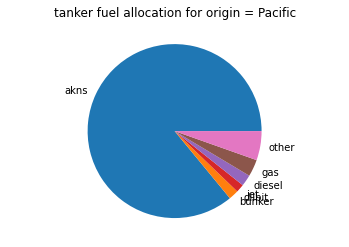

In [34]:
label = 'tanker'
Pacific_tank = [ Pacific[label]['akns']['total_gallons'], 
                Pacific[label]['bunker']['total_gallons'], 
                Pacific[label]['dilbit']['total_gallons'], 
                Pacific[label]['jet']['total_gallons'], 
                Pacific[label]['diesel']['total_gallons'], 
                Pacific[label]['gas']['total_gallons'], 
                Pacific[label]['other']['total_gallons']
               ]
plt.gca().axis("equal")
plt.pie(Pacific_tank, labels= fuel_types)
plt.title(f'{label} fuel allocation for origin = Pacific')

Text(0.5, 1.0, 'atb fuel allocation for origin = Pacific')

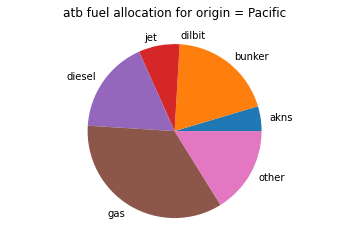

In [35]:
label = 'atb'
Pacific_tank = [ Pacific[label]['akns']['total_gallons'], 
                Pacific[label]['bunker']['total_gallons'], 
                Pacific[label]['dilbit']['total_gallons'], 
                Pacific[label]['jet']['total_gallons'], 
                Pacific[label]['diesel']['total_gallons'], 
                Pacific[label]['gas']['total_gallons'], 
                Pacific[label]['other']['total_gallons']
               ]
plt.gca().axis("equal")
plt.pie(Pacific_tank, labels= fuel_types)
plt.title(f'{label} fuel allocation for origin = Pacific')

Text(0.5, 1.0, 'barge fuel allocation for origin = Pacific')

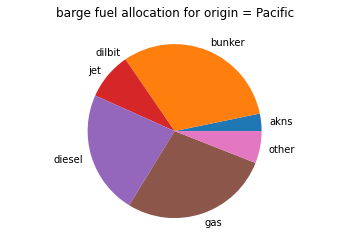

In [36]:
label = 'barge'
Pacific_tank = [ Pacific[label]['akns']['total_gallons'], 
                Pacific[label]['bunker']['total_gallons'], 
                Pacific[label]['dilbit']['total_gallons'], 
                Pacific[label]['jet']['total_gallons'], 
                Pacific[label]['diesel']['total_gallons'], 
                Pacific[label]['gas']['total_gallons'], 
                Pacific[label]['other']['total_gallons']
               ]
plt.gca().axis("equal")
plt.pie(Pacific_tank, labels= fuel_types)
plt.title(f'{label} fuel allocation for origin = Pacific')